# Embedding 활용 텍스트 분석

> imdb 영화 리뷰 데이터셋(영문)

## #01. 준비작업

### [1] 패키지 참조


In [23]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action="ignore")

from helper.util import *
from helper.plot import *
from helper.tensor import *

from tensorflow.keras.preprocessing.sequence import pad_sequences

# 모듈을 사용하지 않고 순정 코드로 구현할 경우
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, Flatten
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기

Tensorflow에 내장된 데이터가 있지만, 동일 데이터를 미리 엑셀로 저장 두었다.


In [3]:
origin = my_read_excel(
    "https://data.hossam.kr/tmdata/imdb.xlsx", categories=["sentiment"]
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sentiment  49998 non-null  category
 1   review     49998 non-null  object  
dtypes: category(1), object(1)
memory usage: 439.7+ KB
None

데이터프레임 상위 5개 행
+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## #02. 데이터 전처리

### [1] 종속변수 라벨링


In [4]:
df = my_labelling(origin, "sentiment")
my_pretty_table(df.head(10))

+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [2] 문자열 전처리

* 축약형 문자열 처리
* 이메일 주소 제거
* HTML 태그 제거
* URL 제거
* 숫자 제거
* 특수문자 제거
* 불용어 제거

#### (1) 영어 불용어 목록


In [9]:
stopwords = my_stopwords("en")
stopwords[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

#### (2) 전처리 수행


In [10]:
%%time

df2 = my_text_data_preprocessing(df, "review", rm_abbr=True, rm_email=True, rm_html=True, rm_url=True, rm_num = True, rm_special=True, stopwords=stopwords)
my_pretty_table(df2.head(10))

+----+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [3] 독립, 종속변수 분리


In [11]:
y = df2["sentiment"]
x = df2["review"]

### [4] 문자열 토큰화

#### (1) 전체 데이터에 대한 토큰화


In [12]:
%%time

tokenizer = my_tokenizer(x)
print(f"전체 단어수: {len(tokenizer.word_index)+1}")

token_set = tokenizer.texts_to_sequences(x)
print("토큰의 크기 :", len(token_set))

# 문장별로 <OOV>의 수 카운트
i = tokenizer.texts_to_sequences(x.head(10))
for j in range(10):
    print(i[j].count(1))
    print(i[j])
    print("-" * 30)

전체 단어수: 216419
토큰의 크기 : 49998
0
[7, 1855, 991, 76, 3228, 322, 3066, 71, 124, 524, 511, 7376, 27, 77, 3151, 3228, 5379, 14719, 63, 514, 211, 124, 594, 69, 1654, 151, 54, 7977, 5575, 11365, 10, 54, 2414, 5791, 5483, 1386, 311, 514, 678, 3292, 280, 271, 60327, 394, 3228, 11041, 277, 15319, 6643, 2464, 986, 60328, 6, 2525, 1289, 24315, 464, 4571, 2420, 1125, 6847, 2861, 12462, 337, 60329, 16758, 246, 4907, 186, 464, 272, 82185, 8105, 39515, 14720, 4998, 7567, 2357, 16759, 60330, 259, 8882, 7164, 13324, 8351, 33517, 46, 145, 19683, 12, 58, 197, 1213, 54, 595, 108, 185, 180, 2870, 749, 101, 1186, 4203, 2399, 1024, 749, 1328, 749, 82186, 903, 104, 4, 27, 322, 2, 56, 119, 3151, 1493, 2111, 2, 58, 2, 1470, 6, 2, 203, 453, 2, 1382, 1163, 3228, 99, 9847, 246, 1992, 2009, 514, 40, 514, 7628, 6848, 4789, 200, 177, 2838, 31314, 6748, 200, 177, 422, 545, 20, 160, 6, 19, 9518, 676, 737, 6748, 587, 1125, 19684, 595, 481, 852, 1908, 1125, 482, 76, 3228, 115, 341, 3641, 3159, 82187, 8, 20, 1130, 3884, 43

#### (2) 각 단어별 빈도수 확인

`(단어: 빈도수)` 형태의 튜플을 원소로 갖는 odict_list 타입 객체를 반환


In [13]:
bins = tokenizer.word_counts.items()
# 출력 결과가 너무 길어서 5개만 출력
print(list(bins)[:5])

[('one', 50324), ('reviewers', 500), ('mentioned', 1026), ('watching', 8909), ('oz', 256)]


#### (3) 자주 등장하는 단어 수 계산


In [14]:
# 사용 빈도가 높다고 판단할 등장 회수
threshold = 30

# 전체 단어의 수
total_cnt = len(tokenizer.word_index)

# 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트할 값
rare_cnt = 0

# 훈련 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
# --> [('one', 50324), ('reviewers', 500), ('mentioned', 1026), ('watching', 8909), ('oz', 256)]
# --> key = 'one', value = 50324
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기 :", total_cnt)
print("등장 빈도가 %s번 미만인 희귀 단어의 수: %s" % (threshold, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

# 자주 등장하는 단어 집합의 크기 구하기 -> 이 값이 첫 번째 학습층의 input 수가 된다.
vocab_size = total_cnt - rare_cnt + 1
print("단어 집합의 크기 :", vocab_size)

단어 집합(vocabulary)의 크기 : 216418
등장 빈도가 30번 미만인 희귀 단어의 수: 201100
단어 집합에서 희귀 단어의 비율: 92.92203051502186
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.597505256648489
단어 집합의 크기 : 15319


#### (4) 자주 등장하는 단어를 제외한 나머지 단어를 OOV로 처리하여 최종 토큰화 진행

`num_words` 를 설정하더라도 전체 단어수나 토큰의 크기에는 영향을 주지 않는다.


In [15]:
%%time

tokenizer2 = my_tokenizer(x, num_words=vocab_size)
print(f"전체 단어수: {len(tokenizer2.word_index) + 1}")

token_set = tokenizer2.texts_to_sequences(x)
print('토큰의 크기 :', len(token_set))

i = tokenizer2.texts_to_sequences(x.head(10))

# 문장별로 <OOV>의 수 카운트
for j in range(10):
    print(i[j].count(1))
    print(i[j])
    print("-" * 30)

전체 단어수: 216419
토큰의 크기 : 49998
16
[7, 1855, 991, 76, 3228, 322, 3066, 71, 124, 524, 511, 7376, 27, 77, 3151, 3228, 5379, 14719, 63, 514, 211, 124, 594, 69, 1654, 151, 54, 7977, 5575, 11365, 10, 54, 2414, 5791, 5483, 1386, 311, 514, 678, 3292, 280, 271, 1, 394, 3228, 11041, 277, 1, 6643, 2464, 986, 1, 6, 2525, 1289, 1, 464, 4571, 2420, 1125, 6847, 2861, 12462, 337, 1, 1, 246, 4907, 186, 464, 272, 1, 8105, 1, 14720, 4998, 7567, 2357, 1, 1, 259, 8882, 7164, 13324, 8351, 1, 46, 145, 1, 12, 58, 197, 1213, 54, 595, 108, 185, 180, 2870, 749, 101, 1186, 4203, 2399, 1024, 749, 1328, 749, 1, 903, 104, 4, 27, 322, 2, 56, 119, 3151, 1493, 2111, 2, 58, 2, 1470, 6, 2, 203, 453, 2, 1382, 1163, 3228, 99, 9847, 246, 1992, 2009, 514, 40, 514, 7628, 6848, 4789, 200, 177, 2838, 1, 6748, 200, 177, 422, 545, 20, 160, 6, 19, 9518, 676, 737, 6748, 587, 1125, 1, 595, 481, 852, 1908, 1125, 482, 76, 3228, 115, 341, 3641, 3159, 1, 8, 20, 1130, 3884, 430]
------------------------------
10
[53, 315, 51, 289, 4, 1277

> 사용 빈도가 낮은 단어들은 모두 `<OOV>` 로 처리되었기 때문에 사용되지 않는 단어의 수가 늘어났다.


#### (5) 토큰화 결과 길이가 0인 문장 찾기


In [16]:
# 토큰화 결과 길이가 0인 항목의 index 찾기
drop_target_index = []

for i, v in enumerate(token_set):
    if len(v) < 1:
        drop_target_index.append(i)

print("길이가 0인 항목의 수: ", len(drop_target_index))

print("길이가 0인 항목의 인덱스 모음: ", drop_target_index)

길이가 0인 항목의 수:  0
길이가 0인 항목의 인덱스 모음:  []


#### (6) 토큰화 결과의 길이가 0인 항목 삭제하기

> 이 예제에서는 길이가 0인 항목이 없지만 코드의 패턴화를 위해 구현해 둔다.


In [17]:
token_set2 = np.asarray(token_set, dtype="object")

# 토큰 결과에서 해당 위치의 항목들을 삭제한다.
fill_token_set = np.delete(token_set2, drop_target_index, axis=0)

# 종속변수에서도 같은 위치의 항목들을 삭제해야 한다.
label_set = np.delete(y, drop_target_index, axis=0)

print("독립변수(덧글) 데이터 수: ", len(fill_token_set))
print("종속변수(레이블) 데이터 수: ", len(label_set))

독립변수(덧글) 데이터 수:  49998
종속변수(레이블) 데이터 수:  49998


## #04. 탐색적 데이터 분석

### [1] 각 문장별로 몇 개의 단어를 포함하고 있는지 측정


In [18]:
word_counts = []

for s in fill_token_set:
    word_counts.append(len(s))

count_df = DataFrame({"count": word_counts})
count_df

,count
0,181
1,94
2,93
3,72
4,130
...,...
49993,98
49994,62
49995,122
49996,120


### [2] 리뷰 중 가장 많은 단어를 사용한 리뷰와 가장 적은 단어를 사용한 리뷰의 단어 수


In [19]:
max_word_count = max(word_counts)
min_word_count = min(word_counts)
print("가장 많은 단어를 사용하는 문장의 단어 수 :", max_word_count)
print("가장 적은 단어를 사용하는 문장의 단어수 :", min_word_count)

가장 많은 단어를 사용하는 문장의 단어 수 : 1508
가장 적은 단어를 사용하는 문장의 단어수 : 4


## #05. 학습 모형 적합

### [1] 패딩처리

최대 단어수를 갖고 있는 문장을 기준으로 그보다 적은 단어를 갖고 있는 문장은 최대 단어수와 동일해 질 때까지 0으로 채워넣는다.


In [20]:
max_word_count = max(word_counts)
pad_token_set = pad_sequences(fill_token_set, maxlen=max_word_count)

#  원래 단어의 앞에 ‘지정해준 단어의 길이(max_word_count) – 원래 단어의 길이`만큼 0이 추가된 것을 볼 수 있다.
print("After pad_sequences: ", len(pad_token_set[0]), len(pad_token_set[1]))
print(pad_token_set[0])

After pad_sequences:  1508 1508
[   0    0    0 ... 1130 3884  430]


### [2] 데이터 분할


In [24]:
x_train, x_test, y_train, y_test = my_train_test_split(pad_token_set, ydata=label_set)

print(
    "훈련용 데이터셋 크기: %s, 검증용 데이터셋 크기: %s" % (x_train.shape, x_test.shape)
)
print("훈련용 레이블 크기: %s, 검증용 레이블 크기: %s" % (y_train.shape, y_test.shape))

훈련용 데이터셋 크기: (39998, 1508), 검증용 데이터셋 크기: (10000, 1508)
훈련용 레이블 크기: (39998,), 검증용 레이블 크기: (10000,)


### [3] 모델 생성

1. input_dim 인자는 학습 데이터셋에서 사용한 단어의 개수(vocab_size)
2. output_dim 인자는 임베딩 벡터의 크기(32)
    - output_dim의 크기는 input_dim보다 작은 값 중에서 설정
    - 이와 같이 인자를 설정하고 나면 Embedding층은 (None, vocab_size, 32) 형태의 출력을 가지게 된다.
3. input_length인자는 Flatten 층을 사용하기 위해 전달.
4. 결국은 문장을 학습하여 긍정, 부정 여부를 판단하는 것이므로 이진분류분석에 속한다.


{'type': 'embedding', 'input_dim': 15319, 'output_dim': 32, 'input_length': 1508}
{'type': 'flatten'}
{'type': 'dense', 'units': 1, 'activation': 'sigmoid'}


0epoch [00:00, ?epoch/s]

+-------+----------+-----------+
|       |      acc |      loss |
|-------+----------+-----------|
| train | 0.971749 | 0.0981908 |
| test  |   0.8875 |  0.281298 |
+-------+----------+-----------+


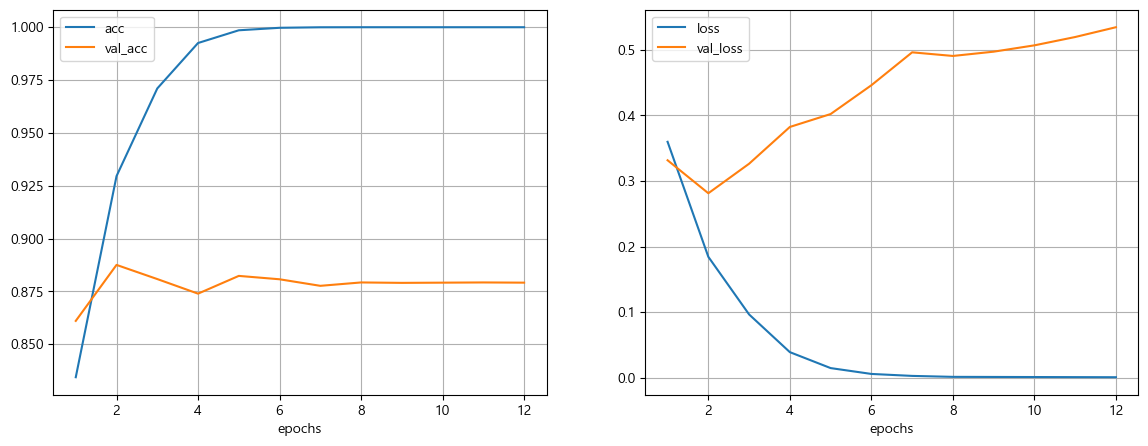

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1508, 32)       │       490,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 48256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        48,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,615,397 (6.16 MB)

 Trainable params: 538,465 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,076,932 (4.11 MB)

CPU times: total: 4min 43s
Wall time: 1min 21s


In [25]:
%%time

# model = Sequential()
# model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_word_count))
# model.add(Flatten())
# model.add(Dense(1, activation="sigmoid"))
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
# model.summary()

model = my_tf(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    layer=[
        dict(type="embedding", input_dim=vocab_size, output_dim=32, input_length=max_word_count),
        dict(type="flatten"),
        dict(type="dense", units=1, activation="sigmoid")
    ],
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["acc"]
)

model.summary()

## #06. 학습 결과 적용

### [1] 검증 데이터에 대한 예측 결과 산정


In [26]:
result = model.predict(x_test)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
10000개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[0.9932504 ],
       [0.00117416],
       [0.9997806 ],
       ...,
       [0.04678622],
       [0.00753035],
       [0.03188464]], dtype=float32)

### [2] 예측 결과를 1차원 배열로 변환


In [27]:
f_results = result.flatten()
f_results = np.round(f_results, 0)
f_results

array([1., 0., 1., ..., 0., 0., 0.], dtype=float32)

### [3] 오차행렬


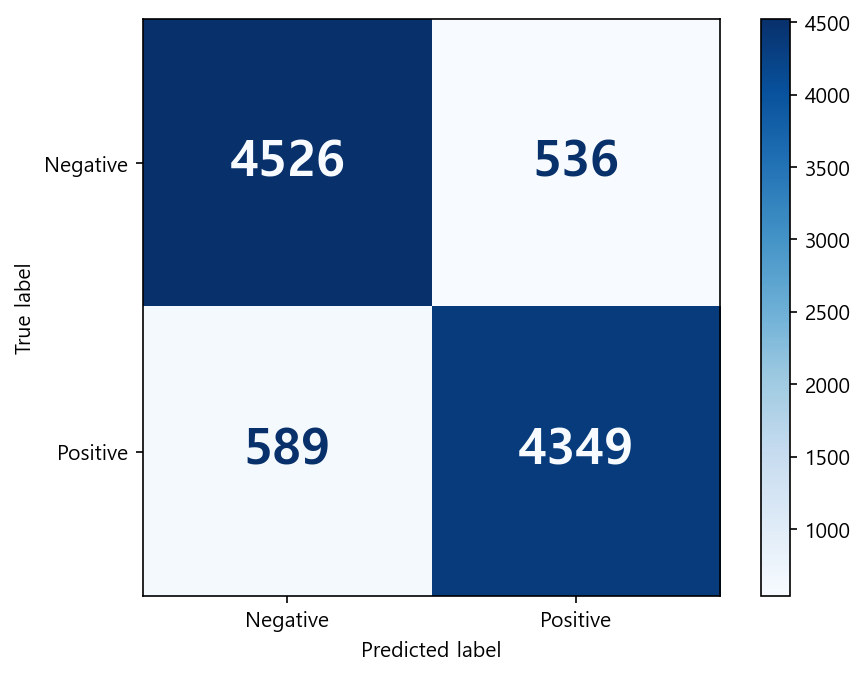

In [28]:
my_confusion_matrix(y_test, f_results, figsize=(7, 5))

## #07. 학습 결과 활용

### [1] 임의의 문장


In [29]:
review = [
    "I had a lot of fun watching it.",
    "I didn't notice how time passed.",
    "I was happy the whole time I watched it.",
    "worst movie",
    "such a boring movie",
]

### [2] 문자열 전처리


In [30]:
review_pre = [my_text_preprocessing(x, stopwords=stopwords) for x in review]
review_pre

['I lot fun watching it',
 'I notice time passed',
 'I happy whole time I watched it',
 'worst movie',
 'boring movie']

### [3] 토큰화


In [31]:
tokenizer2 = my_tokenizer(review_pre, num_words=vocab_size)
print(f"전체 단어수: {len(tokenizer2.word_index) + 1}")

token_set = tokenizer2.texts_to_sequences(review_pre)
print("토큰의 크기 :", len(token_set))

전체 단어수: 16
토큰의 크기 : 5


### [4] 패딩


In [32]:
pad_token_set = pad_sequences(token_set, maxlen=max_word_count)
pad_token_set

array([[ 0,  0,  0, ...,  7,  8,  3],
       [ 0,  0,  0, ...,  9,  4, 10],
       [ 0,  0,  0, ...,  2, 13,  3],
       [ 0,  0,  0, ...,  0, 14,  5],
       [ 0,  0,  0, ...,  0, 15,  5]])

### [5] 예측값 생성


In [33]:
f_results = model.predict(pad_token_set)
data_count, case_count = f_results.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
f_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
5개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[0.7210508 ],
       [0.60641456],
       [0.5404414 ],
       [0.7131678 ],
       [0.6818888 ]], dtype=float32)

### [6] 결과 판정


In [34]:
f_results = np.round(f_results.flatten(), 0)

for i, v in enumerate(review):
    k = "긍정" if f_results[i] == 1 else "부정"
    print(f"[{k}] {v}")

[긍정] I had a lot of fun watching it.
[긍정] I didn't notice how time passed.
[긍정] I was happy the whole time I watched it.
[긍정] worst movie
[긍정] such a boring movie
